In [26]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.path import Path
from matplotlib.patches import PathPatch
import random
import torch
import torch.nn as nn
import math

# Visualisation

In [39]:
def visualize(roadEnv,carEnv):
    """Visualize the road environment"""
    fig, ax = plt.subplots(figsize=(10, 10))

    # Plot center line
    center = np.array(roadEnv.center)
    ax.plot(center[:, 0], center[:, 1], 'k--', linewidth=1, label='Center')

    # Plot left edge
    left = np.array(roadEnv.left_edge)
    ax.plot(left[:, 0], left[:, 1], 'b-', linewidth=2, label='Left Edge')

    # Plot right edge
    right = np.array(roadEnv.right_edge)
    ax.plot(right[:, 0], right[:, 1], 'r-', linewidth=2, label='Right Edge')

    # Fill the road area
    road_polygon = np.vstack((left, right[::-1]))
    ax.fill(road_polygon[:, 0], road_polygon[:, 1], color='gray', alpha=0.3)

    # Car location and direction as arrow
    car_loc_x = carEnv.car_state["location"][0]
    car_loc_y = carEnv.car_state["location"][1]
    car_dir = carEnv.car_state["direction"]
    
    

    arrow = plt.arrow(car_loc_x, car_loc_y, 0.2 * np.cos(car_dir), 0.2 * np.sin(car_dir), color='b', width=0.02)

    ax.add_patch(arrow)
    
    # Car trajectory
    trajectory = carEnv.trajectory.copy()  # Get a copy of the trajectory
    if len(trajectory) > 1:  # Check if there's more than one point
        x_traj, y_traj = zip(*trajectory)  # Unpack coordinates if trajectory has points
        ax.plot(x_traj, y_traj, 'r-', linewidth=1, label='Trajectory')

    

    
    # Set plot properties
    ax.set_aspect('equal', 'box')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title('Road Environment')
    ax.legend(loc='upper right')
    ax.grid(True)

    # Adjust the plot limits
    all_points = np.vstack((roadEnv.center, roadEnv.left_edge, roadEnv.right_edge))
    margin = roadEnv.width
    ax.set_xlim(min(all_points[:, 0]) - margin, max(all_points[:, 0]) + margin)
    ax.set_ylim(min(all_points[:, 1]) - margin, max(all_points[:, 1]) + margin)

    plt.show()

# Env

In [244]:
class RoadEnvironment:
    def __init__(self, data_points, width, length, closed=True):
        """
        Initialize the road environment.
        
        :param data_points: List of (x, y) tuples representing road points
        :param width: Width of the road (distance from center to edge)
        :param closed: Boolean indicating if the road is a closed loop
        """
        self.data_points = np.array(data_points)
        self.width = width
        self.length = length
        self.closed = closed
        self.road_path = self._generate_road_path()
        
        # more parameters
        self.resulotion = 0.1
        
    def _generate_road_path(self):
        self.center = [(0,0),(0,10)]
        self.left_edge = [(self.width,0),(self.width,10)]
        self.right_edge = [(-self.width,0),(-self.width,10)]
        
    
    def on_road(self,loc,direction):
        x = loc[0]
        y = loc[1]
        # Check road boundaries using individual conditions
        if  -self.width < x < self.width and 0 <= y < self.length and 0 < direction <  np.pi:
            return True
        else:
            return False
    
    def sensors(self, loc, direction, n): #number of sensors
        min_dir = direction - .5 * np.pi
        max_dir = direction + .5 * np.pi
        directions = np.linspace(min_dir, max_dir, n)
        distanses = []
        
        for i in directions:
            temp_loc = loc.copy()
            dis = 0
            while self.on_road(temp_loc,direction = 0.5*np.pi) and dis < 20:
                temp_loc[0] +=  self.resulotion *  math.cos(i)
                temp_loc[1] +=  self.resulotion *  math.sin(i)
                dis += self.resulotion
            distanses.append(dis)
            
        print(f'temp_loc ={loc}, direction ={direction},\n   direction ={directions},\n    dis = {distanses}')
        return distanses
          

        



In [258]:
class CarEnvironment:
    def __init__(self,RoadEnv,max_speed=5):
        self.max_speed = max_speed
        self.reset()  # Initialize car state
        

    def reset(self):
        self.car_state = {
            "location": [0,0],
            "speed": .5,
            "direction": np.pi/2  }# + np.random.uniform(-.4, .4) }
        self.Terminal = False
        self.trajectory = [self.car_state["location"].copy()]
  
    
    def distance_to_edge(self):
        """  Calculate the distance to the closest edge of the road. """
        x = self.car_state["location"][0]
        return min([abs(x),abs(-x)])  # Replace with actual distance calculation

    def step(self, action):
        # Update car state based on action         
        self.car_state["direction"] = self.car_state["direction"] + np.squeeze(action)

        # Move the car based on speed and direction
        dx = self.car_state['speed'] * math.cos(self.car_state["direction"])
        dy = self.car_state['speed'] * math.sin(self.car_state["direction"])
     
        self.car_state["location"][0] += dx
        self.car_state["location"][1] += dy
              
        self.trajectory.append(np.array(self.car_state["location"].copy()))
        
        self.Terminal = RoadEnv.on_road(self.car_state["location"],self.car_state["direction"])
        
        
        
        if self.Terminal:
            reward = -10
        else:
            reward = -self.distance_to_edge()

class CarAgent(nn.Module):
    def __init__(self, state_size=5, action_size=1):
        super(CarAgent, self).__init__()
        self.state_size = state_size
        self.action_size = action_size
        self.build_model()

    def build_model(self):
        # Define the neural network architecture
        self.fc1 = nn.Linear(self.state_size, 32)
        self.fc2 = nn.Linear(32, 8)
        self.fc3 = nn.Linear(8, 4)
        self.fc4 = nn.Linear(4, self.action_size)

    def forward(self, x):
        """
        Define the forward pass of the neural network.
        """
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

    def act(self, state):
        """
        Predict an action based on the input state.
        """
        state = RoadEnv.sensors( state["location"].copy(), state["direction"], n=self.state_size)  
        state = torch.tensor(state, dtype=torch.float).unsqueeze(0)  # Convert to tensor and add batch dim
        action = self.forward(state)
        print(f'action = {action}')
        return action.detach().numpy()[0]  # Detach and convert back to numpy array
    

temp_loc =[0, 0], direction =1.5707963267948966,
   direction =[0.         0.78539816 1.57079633 2.35619449 3.14159265],
    dis = [1.0999999999999999, 1.5000000000000002, 10.09999999999998, 1.5000000000000002, 1.0999999999999999]
action = tensor([[0.1535]], grad_fn=<AddmmBackward0>)
temp_loc =[-0.07644958305800718, 0.49412089740290976], direction =1.7242975989964346,
   direction =[0.15350127 0.93889944 1.7242976  2.50969576 3.29509393],
    dis = [1.0999999999999999, 1.9000000000000006, 6.099999999999994, 1.2, 0.9999999999999999]
action = tensor([[0.1847]], grad_fn=<AddmmBackward0>)
temp_loc =[-0.2423466377915528, 0.9657968107488586], direction =1.9090011129763464,
   direction =[0.33820479 1.12360295 1.90900111 2.69439928 3.47979744],
    dis = [1.4000000000000001, 2.9000000000000012, 2.3000000000000007, 0.8999999999999999, 0.8999999999999999]
action = tensor([[0.1736]], grad_fn=<AddmmBackward0>)
CarEnv = [[0, 0], array([-0.07644958,  0.4941209 ]), array([-0.24234664,  0.96579681]),

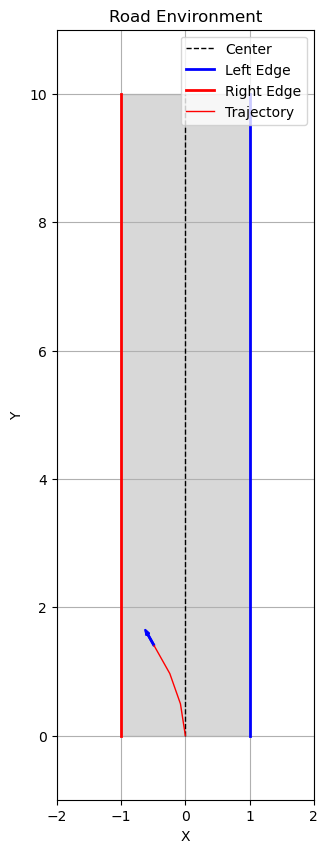

In [266]:
RoadEnv = RoadEnvironment(data_points= [(0, 0), (0, 10)], width=1,length =10, closed=False)
CarEnv  = CarEnvironment(RoadEnv)
car_agent = CarAgent()


action = car_agent.act(CarEnv.car_state)
CarEnv.step(action)
action = car_agent.act(CarEnv.car_state)
CarEnv.step(action)
action = car_agent.act(CarEnv.car_state)
CarEnv.step(action)

print(f'CarEnv = {CarEnv.trajectory}')
visualize(RoadEnv,CarEnv)

In [385]:
random.uniform(-.4, .4)+np.pi/2 

1.4154536623410654